In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/Users/Jian/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import re

In [3]:
import datetime

In [4]:
import os

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from plotting import *

In [7]:
LOSS_INDEX = 3

## Acquisition

### Load logs from selected experiment

In [80]:
def get_all_configs(experiment_directory, n_workers):
    parameter_values = {}

    all_configs = []

    if not type(experiment_directory) == list:
        experiment_directory = [experiment_directory]

    for this_exp_dir in experiment_directory:
        print
        print 'From directory ' + this_exp_dir
        for fname in os.listdir(this_exp_dir):
            if fname[-4:]!='.log':
                print fname
                continue
            assert(fname[-4:]=='.log')
            parameter_strings = fname[:-4].split('_')
            print 'Loading ' + fname
            for pstring in parameter_strings:
                p,v = pstring.split('=')
                parameter_values[p] = float(v)
                if p=='W':
                    assert(int(v)==n_workers)
            print this_exp_dir + '/' + fname
            all_lines = load_results(this_exp_dir + '/' + fname)
            all_configs.append([parameter_values.copy(), all_lines])
    return all_configs

In [81]:
def get_he_se_numbers_from_log_lines(all_lines,n,g,group_batch=True):

    all_seconds, all_losses = get_times_losses(all_lines)

    iters =[line[2] for line in all_lines]
    
    if group_batch:
        # Each group is responsible of a mini-batch
        total_batches=g*(np.max(iters)-iters[0])
    else:
        # Each worker is responsible for a mini-batch
        total_batches=n*(np.max(iters)-iters[0])

    total_time = all_seconds[-1]

    seconds_per_batch = total_time/total_batches
    
    return seconds_per_batch, total_batches, total_time

In [82]:
def plot_HE_curve(all_seconds_per_batch, pdf_file=None):
    all_seconds_per_batch = np.array(all_seconds_per_batch)
    plt.plot(np.array(all_g),all_seconds_per_batch/all_seconds_per_batch[0],'o-', linewidth=3)
    plt.grid()
    plt.ylabel('HE Penalty', fontsize=21)
    plt.axis([None, None, 0, 1]);
    plt.xlabel('Number of trees (groups)', fontsize=21)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tight_layout()
    if pdf_file != None:
        plt.savefig(pdf_file)

In [83]:
def get_per_sample_time(n_workers, batch_size, use_group_batch_size, all_g, experiment_directory):
    # if using group batch size, batch_size equals to the samples per-iteration for the whole group
    # if using worker batch size, batch_size equals to the samples per-iteration for each worker
    all_configs = get_all_configs(experiment_directory, n_workers)
    best_configs = get_best_config_per_group(n_workers, all_configs, W=10)
    per_sample_time = []
    for G in all_g:
        res = get_he_se_numbers_from_log_lines(best_configs[G][1], n_workers, G, group_batch=use_group_batch)
        per_sample_time.append(res[0] / batch_size )
    per_sample_time = min(per_sample_time)
    return per_sample_time

In [124]:
def get_dirs(path, tag):
    dir_list = [d for d in os.listdir(path) if os.path.isdir(path + d) and tag in d]
    assert len(dir_list) == 1
    return dir_list[0]

In [85]:
base_dir = '/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/'

## Async branch 1-group scaling

In [105]:
per_sample_time = []
n_workers_list = [1,2,4,8,16,32,64,128,256]
batch_size = 4
use_group_batch = False

In [106]:
for n_workers in n_workers_list:
    all_g = [1, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    
    
    print experiment_directory
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )
    
per_sample_time_1_group = per_sample_time
all_n_workers_1_group = n_workers_list

['/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w1_async_b4_W1_2016-12-21-18:38']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w1_async_b4_W1_2016-12-21-18:38
Loading W=1_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w1_async_b4_W1_2016-12-21-18:38/W=1_G=1_LR=0.0003_mu=0.0.log
['/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05
Loading W=2_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05/W=2_G=1_LR=0.0003_mu=0.0.log
Loading W=2_G=2_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05/W=2_G=2_LR=0.0003_mu=0.0.log

In [107]:
print per_sample_time_1_group

[0.21435402511078286, 0.1020765235148515, 0.05544922395079595, 0.0423939307735426, 0.018700997487113402, 0.011132330176483813, 0.00499340283203125, 0.0034308022594451903, 0.001725838946496212]


## Async branch 2-group scaling

In [90]:
per_sample_time = []
n_workers_list = [2,4,8,16,32,64,128,256]
batch_size = 4
use_group_batch = False

In [91]:
for n_workers in n_workers_list:
    all_g = [2, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )

per_sample_time_2_group = per_sample_time
all_n_workers_2_group = n_workers_list


From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05
Loading W=2_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05/W=2_G=1_LR=0.0003_mu=0.0.log
Loading W=2_G=2_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05/W=2_G=2_LR=0.0003_mu=0.0.log

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w4_async_b4_W4_2016-12-21-19:20
Loading W=4_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w4_async_b4_W4_2016-12-21-19:20/W=4_G=1_LR=0.0003_mu=0.0.log
Loading W=4_G=2_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w4_async_b4_W4_2016-12-21-19:20/W=4_G=2_LR=0.0003_mu=0.0.log
Loading W=4_G=4_LR=0.0003_mu=0.0.log
/Users/Jian/D

In [92]:
print per_sample_time_2_group

[0.13928697129981024, 0.04071625497477579, 0.032573713435374144, 0.019167763245884775, 0.013313845448369565, 0.005470825045665481, 0.002887813426389745, 0.0016483264250963072]


## Async branch full async scaling

In [111]:
per_sample_time = []

In [112]:
n_workers_list = [1,2,4,8,16,32,64,128,256]

In [113]:
for n_workers in n_workers_list:
    all_g = [n_workers, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )
    
per_sample_time_n_workers_group = per_sample_time
all_n_workers_n_workers_group = n_workers_list


From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w1_async_b4_W1_2016-12-21-18:38
Loading W=1_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w1_async_b4_W1_2016-12-21-18:38/W=1_G=1_LR=0.0003_mu=0.0.log

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05
Loading W=2_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05/W=2_G=1_LR=0.0003_mu=0.0.log
Loading W=2_G=2_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w2_async_b4_W2_2016-12-22-00:05/W=2_G=2_LR=0.0003_mu=0.0.log

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/w4_async_b4_W4_2016-12-21-19:20
Loading W=4_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/lo

In [114]:
print per_sample_time_n_workers_group

[0.21435402511078286, 0.13928697129981024, 0.05786321212715855, 0.03901009781766529, 0.020555514661343612, 0.016409015343105668, 0.010671182452253535, 0.015364129939516129, 0.013173528512549212]


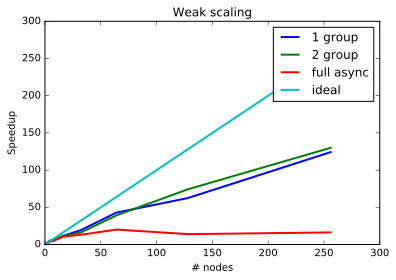

In [117]:
baseline = per_sample_time_1_group[0]
plt.plot(np.array(all_n_workers_1_group), baseline / np.array(per_sample_time_1_group), linewidth=2, label="1 group")
plt.plot(np.array(all_n_workers_2_group), baseline / np.array(per_sample_time_2_group), linewidth=2, label="2 group")
plt.plot(np.array(all_n_workers_n_workers_group), baseline / np.array(per_sample_time_n_workers_group), linewidth=2, label="full async")
plt.plot(all_n_workers_n_workers_group, all_n_workers_n_workers_group, linewidth=2, label="ideal")
plt.legend()
plt.xlabel("# nodes")
plt.ylabel("Speedup")
plt.title("Weak scaling")

# Below this line the staff is not relevant

In [130]:
base_dir = '/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/'

## Async branch 1-group scaling

In [131]:
per_sample_time = []
n_workers_list = [256,]
batch_size = 4
use_group_batch = False

In [132]:
for n_workers in n_workers_list:
    all_g = [1, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    
    
    print experiment_directory
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )
    
per_sample_time_1_group = per_sample_time
all_n_workers_1_group = n_workers_list

['/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46
.DS_Store
Loading W=256_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46/W=256_G=1_LR=0.0003_mu=0.0.log
    stride: 2I1222 15:09:37.859104 232330 solver.cpp:291] [187] Iteration 1, loss = 10.7665

    stride: 2I1222 15:09:37.779243 245072 solver.cpp:291] [77] Iteration 1, loss = 55.7802

  name: "lossI1222 15:09:40.628485 245072 solver.cpp:291] [77] Iteration 2, loss = 0

    stride: 2I1222 15:09:40.652606 232257 solver.cpp:291] [186] Iteration 2, loss = 0

  name: "lossI1222 15:09:42.881649 232257 solver.cpp:291] [186] Iteration 3, loss = 0

  name: "lossI1222 15:09:46.636077 232627 solver.cpp:291] [72] Iteration 5, loss = 0



In [133]:
print per_sample_time_1_group

[0.0018539152802422134]


## Async branch 2-group scaling

In [134]:
per_sample_time = []
n_workers_list = [256,]
batch_size = 4
use_group_batch = False

In [135]:
for n_workers in n_workers_list:
    all_g = [2, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )

per_sample_time_2_group = per_sample_time
all_n_workers_2_group = n_workers_list


From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46
.DS_Store
Loading W=256_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46/W=256_G=1_LR=0.0003_mu=0.0.log
    stride: 2I1222 15:09:37.859104 232330 solver.cpp:291] [187] Iteration 1, loss = 10.7665

    stride: 2I1222 15:09:37.779243 245072 solver.cpp:291] [77] Iteration 1, loss = 55.7802

  name: "lossI1222 15:09:40.628485 245072 solver.cpp:291] [77] Iteration 2, loss = 0

    stride: 2I1222 15:09:40.652606 232257 solver.cpp:291] [186] Iteration 2, loss = 0

  name: "lossI1222 15:09:42.881649 232257 solver.cpp:291] [186] Iteration 3, loss = 0

  name: "lossI1222 15:09:46.636077 232627 solver.cpp:291] [72] Iteration 5, loss = 0

    stride: 2I1222 15:09:48.380045 221503 solver.cpp:291] [4] Iteration 6, loss = 0

    stride: 2I1222 15:09:48.418721 221737 

In [136]:
print per_sample_time_2_group

[0.0014727011198906845]


### 1 worker

In [18]:
n_workers = 1
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w1_master_W1_2016-12-20-02:16'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w1_master_W1_2016-12-20-02:16
Loading W=1_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w1_master_W1_2016-12-20-02:16/W=1_G=1_LR=0.0003_mu=0.0.log
[0.16924877504553731]


### 4 worker

In [19]:
n_workers = 4
use_group_batch = False
batch_size = 1
all_g = [1,2,4,]
experiment_directory='w4_async_per_worker_W4_2016-12-20-01:08'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w4_async_per_worker_W4_2016-12-20-01:08
Loading W=4_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w4_async_per_worker_W4_2016-12-20-01:08/W=4_G=1_LR=0.0003_mu=0.0.log
Loading W=4_G=2_LR=0.0003_mu=0.0.log
../log_archiv_cori/w4_async_per_worker_W4_2016-12-20-01:08/W=4_G=2_LR=0.0003_mu=0.0.log
Loading W=4_G=4_LR=0.0003_mu=0.0.log
../log_archiv_cori/w4_async_per_worker_W4_2016-12-20-01:08/W=4_G=4_LR=0.0003_mu=0.0.log
[0.04628588049853372, 0.034214421875000005, 0.054536240719910006]


### 16 worker

In [20]:
n_workers = 16
use_group_batch = False
batch_size = 1
all_g = [1,2,4,8,16]
experiment_directory='w16_async_per_worker_W16_2016-12-20-01:49'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory))


From directory ../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49
Loading W=16_G=16_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=16_LR=0.0003_mu=0.0.log
Loading W=16_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=1_LR=0.0003_mu=0.0.log
Loading W=16_G=2_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=2_LR=0.0003_mu=0.0.log
Loading W=16_G=4_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=4_LR=0.0003_mu=0.0.log
Loading W=16_G=8_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=8_LR=0.0003_mu=0.0.log
[0.015922215458387515, 0.014282216787790698, 0.011960878951848249, 0.011319198090277777, 0.022907568973634652]


### 64 worker

In [21]:
n_workers = 64
use_group_batch = False
batch_size = 1
all_g = [1,2,4,8,16,32,64]
experiment_directory='w64_async_per_worker_W64_2016-12-20-00:10'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10
Loading W=64_G=16_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=16_LR=0.0003_mu=0.0.log
Loading W=64_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=1_LR=0.0003_mu=0.0.log
Loading W=64_G=2_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=2_LR=0.0003_mu=0.0.log
Loading W=64_G=32_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=32_LR=0.0003_mu=0.0.log
Loading W=64_G=4_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=4_LR=0.0003_mu=0.0.log
Loading W=64_G=64_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=64_LR=0.0003_mu=0.0.log
Loading W=64_G=8_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=8_LR=0.0003_mu=0.0.log
[0.00462765067

In [22]:
per_sample_time_async = per_sample_time

## Master branch scaling

In [23]:
per_sample_time = []

### 1 worker

In [24]:
n_workers = 1
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w1_master_W1_2016-12-20-02:16'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w1_master_W1_2016-12-20-02:16
Loading W=1_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w1_master_W1_2016-12-20-02:16/W=1_G=1_LR=0.0003_mu=0.0.log
[0.16924877504553731]


### 4 worker

In [25]:
n_workers = 4
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w4_master_W4_2016-12-20-01:03'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w4_master_W4_2016-12-20-01:03
Loading W=4_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w4_master_W4_2016-12-20-01:03/W=4_G=1_LR=0.0003_mu=0.0.log
[0.04835493585192698]


### 16 worker

In [26]:
n_workers = 16
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w16_master_W16_2016-12-20-01:44'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory))


From directory ../log_archiv_cori/w16_master_W16_2016-12-20-01:44
Loading W=16_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_master_W16_2016-12-20-01:44/W=16_G=1_LR=0.0003_mu=0.0.log
[0.015674151729060913]


### 64 worker

In [27]:
n_workers = 64
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w64_master_W64_2016-12-20-00:05'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w64_master_W64_2016-12-20-00:05
Loading W=64_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_master_W64_2016-12-20-00:05/W=64_G=1_LR=0.0003_mu=0.0.log
[0.0048237595942982455]


In [28]:
per_sample_time_master = per_sample_time

### plot weak scaling scaling number

[0.16924877504553731, 0.034214421875000005, 0.011319198090277777, 0.0038706594905878466]
[0.16924877504553731, 0.04835493585192698, 0.015674151729060913, 0.0048237595942982455]


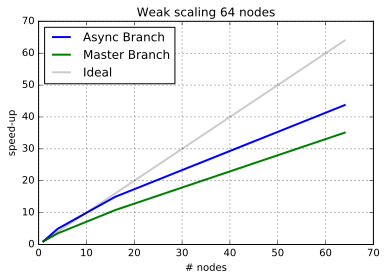

In [30]:
n_nodes = np.array( [1,4,16,64] )
print per_sample_time_async
speed_up = 1 / np.array(per_sample_time_async)
plt.plot(n_nodes, speed_up/speed_up[0], linewidth=2, label="Async Branch")
print per_sample_time_master
speed_up = 1 / np.array(per_sample_time_master)
plt.plot(n_nodes, speed_up/speed_up[0], linewidth=2, label="Master Branch")
plt.plot(n_nodes, n_nodes, linewidth=2, label="Ideal", color='k', alpha=0.2)
plt.title("Weak scaling 64 nodes")
plt.grid()
plt.xlabel("# nodes")
plt.ylabel("speed-up")
plt.legend(loc='upper left')
plt.show();